## Ablation Study: DnD Without Best Concept Selection (Step 3)

In [1]:
# Import libraries

import os
import sys
sys.path.append("..")

import torch
import utils
import data_utils
import DnD_models
import scoring_function

import pandas as pd
import random

from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler

from transformers import BlipProcessor, BlipForConditionalGeneration

### Experiment Settings

In [2]:
# Define variables for dissection

figure = 'fig3a'

settings = {'fig3a': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer2', "ids_to_check": [312]}, 
            'fig3b': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer3', "ids_to_check": [927]},
           }

clip_name = 'ViT-B/16'
target_name = settings[figure]["target_name"]
target_layer = settings[figure]["target_layer"]
d_probe = settings[figure]["d_probe"]

batch_size = 200
device = 'cuda'
pool_mode = 'avg'

results_dir = 'exp_results'
saved_acts_dir = 'saved_activations'
num_images_to_check = 10
blip_batch_size = 10
tag = "concept_selection_ablation"

ids_to_check = settings[figure]["ids_to_check"]

### Load Models

In [3]:
# Load BLIP model

BLIP_PATH = ""

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device) 
pretrained_dict = torch.load(BLIP_PATH)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
model.eval()

/scratch/nbai/job_36799419/ipykernel_731029/3534641851.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(BLIP_PATH)


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [4]:
# Initialize Stable Diffusion

model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))
generator = torch.Generator(device=device).manual_seed(0)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Set Up Results File

In [5]:
# Setting up file/directory paths for saving results
pot_column_names = ['Neuron ID'] + ['Concept {}'.format(i) for i in range(5)]
all_concepts = pd.DataFrame(columns=pot_column_names)
result_column_names = ['Neuron ID', 'Label 1']
final_concepts = pd.DataFrame(columns=result_column_names)

In [6]:
# Create results folder
results_path = utils.create_layer_folder(results_dir = results_dir, base_dir = ".", target_name = target_name, 
                          d_probe = d_probe, layer = target_layer, tag = tag)

### Construct Augmented Probing Data (DnD Step 1)

In [7]:
# Get activations
target_save_name = utils.get_save_names(target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  pool_mode=pool_mode, base_dir = '.', saved_acts_dir = saved_acts_dir)

utils.save_activations(target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, batch_size = batch_size, device = device,
                       pool_mode=pool_mode, base_dir = '.', saved_acts_dir = saved_acts_dir)

target_feats = torch.load(target_save_name, map_location='cpu')

pil_data = data_utils.get_data(d_probe)

/scratch/nbai/job_36799419/ipykernel_731029/3116229814.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  target_feats = torch.load(target_save_name, map_location='cpu')


In [8]:
# Find top activating images
top_vals, top_ids = torch.topk(target_feats, k=num_images_to_check, dim=0)

all_imgs = []
all_img_ids = {neuron_id:[] for neuron_id in ids_to_check}

# Find top activating image crops
for t, orig_id in enumerate(ids_to_check):
    print("Cropping for Neuron {}/{}".format(t+1,len(ids_to_check)))
    
    activating_images = []
    for i, top_id in enumerate(top_ids[:, orig_id]):
        
        # Reshape activating images
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        
        # Add image to d_probe with image ID
        all_img_ids[orig_id].append(len(all_imgs))
        all_imgs.append(im)
        activating_images.append(im)
        
    cropped_images = []
    
    # Get crops - FC layers do not have feature maps
    if(target_layer != 'fc'):
        cropped_images = DnD_models.get_attention_crops(target_name, activating_images, orig_id, num_crops_per_image = 4, target_layers = [target_layer], device = device)

    # Add crops into d_probe with image ID
    for img in cropped_images:
        all_img_ids[orig_id].append(len(all_imgs))
        all_imgs.append(img)

Cropping for Neuron 1/1


### Generative Captioning – Final Concept (DnD Step 2)

Neuron: 312 (1/1)


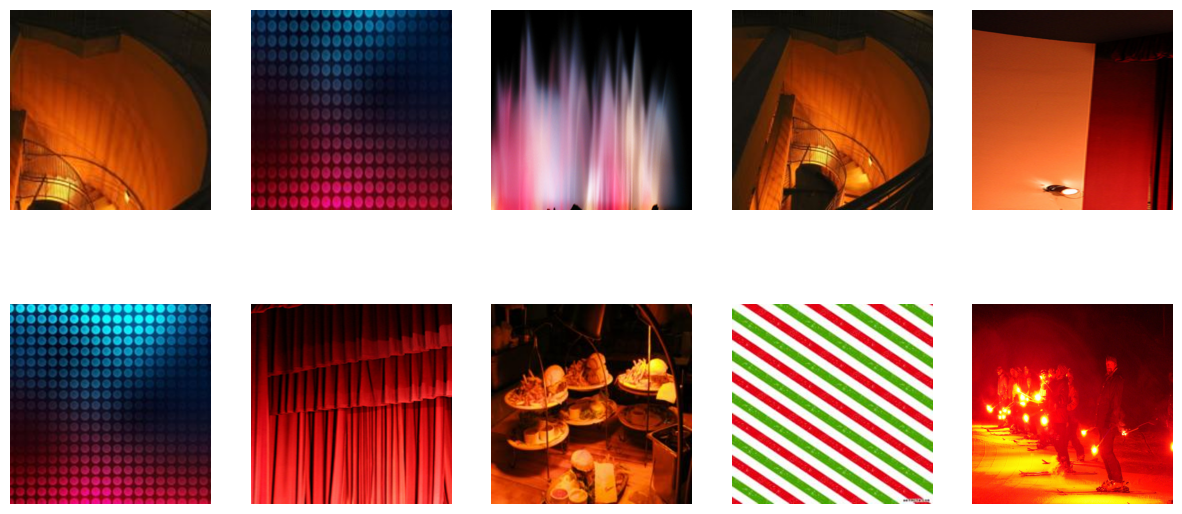

100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Image 1 caption: a large metal furnace with a large flame
Image 2 caption: abstract background with colorful circles - free vector 12779
Image 3 caption: a black background with a red and white light
Image 4 caption: a large metal structure
Image 5 caption: a bed with a red blanket
Image 6 caption: abstract background with colorful circles
Image 7 caption: a red curtain on a stage
Image 8 caption: a table with a lot of food on it
Image 9 caption: christmas candy stripe pattern
Image 10 caption: a group of people
DnD Concept Generation Label: Vibrant Textures and Structures


In [9]:
# Get target activations with D_probe + D_cropped
target_feats = utils.get_target_activations(target_name, all_imgs, [target_layer])

# Find top activating images
top_vals, top_ids = torch.sort(target_feats, dim=0, descending = True)
comp_words = {orig_id : [] for orig_id in ids_to_check}
top_images = {orig_id:[] for orig_id in ids_to_check}

# Step 2 - Generate Candidate Concepts
for neuron_num, orig_id in enumerate(ids_to_check):
    print("Neuron: {} ({}/{})".format(orig_id, neuron_num+1, len(ids_to_check)))

    # Plot and save highest activating images
    fig, images, top_images = utils.get_top_images(orig_id, top_ids, top_images, 
                                                   all_imgs, all_img_ids, num_images_to_check, 
                                                   blip_batch_size)
    utils.save_activating_fig(fig, results_path, orig_id)
    
    # Generate and simplify BLIP Captions
    descriptions = DnD_models.blip_caption(model, processor, images, blip_batch_size, device)
    for i, description in enumerate(descriptions):
        descriptions[i] = DnD_models.GPT_simplify(description)
    
    # Combining BLIP descriptions into one description
    final_label = DnD_models.GPT_model_single(descriptions)
    final_concepts.loc[len(final_concepts)] = [orig_id] + [final_label]
    print("DnD Concept Generation Label: {}".format(final_label))

utils.save_final_results(final_concepts, results_path)